This is a **beginner's** notebook to understand the tensorflow pipeline and feature engineering on tensorflow

# Import Libraries and dataset

In [1]:
import numpy as np
import pandas as pd

import tensorflow as tf

from tensorflow import feature_column
from tensorflow.keras import layers
from sklearn.model_selection import train_test_split

In [2]:
df=pd.read_csv("/kaggle/input/pet-finder/petfinder-mini.csv")
df.head()

,Type,Age,Breed1,Gender,Color1,Color2,MaturitySize,FurLength,Vaccinated,Sterilized,Health,Fee,Description,PhotoAmt,AdoptionSpeed
0,Cat,3,Tabby,Male,Black,White,Small,Short,No,No,Healthy,100,Nibble is a 3+ month old ball of cuteness. He ...,1,2
1,Cat,1,Domestic Medium Hair,Male,Black,Brown,Medium,Medium,Not Sure,Not Sure,Healthy,0,I just found it alone yesterday near my apartm...,2,0
2,Dog,1,Mixed Breed,Male,Brown,White,Medium,Medium,Yes,No,Healthy,0,Their pregnant mother was dumped by her irresp...,7,3
3,Dog,4,Mixed Breed,Female,Black,Brown,Medium,Short,Yes,No,Healthy,150,"Good guard dog, very alert, active, obedience ...",8,2
4,Dog,1,Mixed Breed,Male,Black,No Color,Medium,Short,No,No,Healthy,0,This handsome yet cute boy is up for adoption....,3,2


# Exploratory Data Analysis

In [3]:
df.nunique()

Type                 2
Age                105
Breed1             166
Gender               2
Color1               7
Color2               7
MaturitySize         3
FurLength            3
Vaccinated           3
Sterilized           3
Health               3
Fee                 65
Description      10691
PhotoAmt            31
AdoptionSpeed        5
dtype: int64

In [4]:
df["AdoptionSpeed"].unique()

array([2, 0, 3, 1, 4])

# Splitting dataset into test, train and validation sets

In [5]:
# We're changing target to adopted or not; i.e; 1 and 0
df['target'] = np.where(df['AdoptionSpeed']==4, 0, 1)

# Drop un-used columns
df = df.drop(columns=['AdoptionSpeed', 'Description'])

In [6]:
train, test = train_test_split(df, test_size=0.2)
train, val = train_test_split(train, test_size=0.2)
print(len(train), 'train examples')
print(len(val), 'validation examples')
print(len(test), 'test examples')

7383 train examples
1846 validation examples
2308 test examples


In [7]:
# Function to convert Pandas dataframe to tf.data dataset

def df_to_dataset(dataframe, shuffle=True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dict(dataframe), labels))
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  ds = ds.batch(batch_size)
  return ds

# Examples of types of transforms

In [8]:
batch_size=5 # Just to show examples
train_ds = df_to_dataset(train, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)

In [9]:
# We will use this batch to demonstrate several types of feature columns
example_batch = next(iter(train_ds))[0]

# Demo funtion to show outputs
def demo(feature_column):
  feature_layer = layers.DenseFeatures(feature_column)
  print(feature_layer(example_batch).numpy())

In [10]:
# Numeric Column
photo_count = feature_column.numeric_column('PhotoAmt')
demo(photo_count)

[[0.]
 [1.]
 [7.]
 [5.]
 [1.]]


In [11]:
#Bucketized column
age = feature_column.numeric_column('Age')
age_buckets = feature_column.bucketized_column(age, boundaries=[1, 3, 5])
demo(age_buckets)

[[0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 0. 0. 1.]
 [0. 1. 0. 0.]]


In [12]:
# Categorical Column
animal_type = feature_column.categorical_column_with_vocabulary_list('Type', ['Cat', 'Dog'])

animal_type_one_hot = feature_column.indicator_column(animal_type)
demo(animal_type_one_hot)

[[0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [1. 0.]]


In [13]:
# Embedding Column
breed1 = feature_column.categorical_column_with_vocabulary_list('Breed1', df.Breed1.unique())
breed1_embedding = feature_column.embedding_column(breed1, dimension=8)
demo(breed1_embedding)

[[-0.04949184  0.24948318 -0.03266084  0.42500082  0.70691466  0.0572838
   0.17635192  0.19759831]
 [ 0.09084342 -0.37408945  0.20877913 -0.35410488  0.08557156  0.04221291
   0.05211003  0.12776087]
 [-0.0199446  -0.01025164  0.13671662 -0.14664555 -0.08698592 -0.1046999
  -0.05640865  0.24487662]
 [ 0.68686754 -0.66422445  0.40631634 -0.22062324 -0.37116402 -0.4213966
   0.36919942  0.41410142]
 [ 0.68686754 -0.66422445  0.40631634 -0.22062324 -0.37116402 -0.4213966
   0.36919942  0.41410142]]


In [14]:
#Hashing Column
breed1_hashed = feature_column.categorical_column_with_hash_bucket('Breed1', hash_bucket_size=10)
demo(feature_column.indicator_column(breed1_hashed))

[[0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]]


In [15]:
#Crossed feature columns
crossed_feature = feature_column.crossed_column([age_buckets, animal_type], hash_bucket_size=10)
demo(feature_column.indicator_column(crossed_feature))

[[0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
 [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]]


# Feature engineering with Tensorflow 

In [16]:
feature_columns = []

# numeric cols
for header in ['PhotoAmt', 'Fee', 'Age']:
  feature_columns.append(feature_column.numeric_column(header))

# bucketized cols
age = feature_column.numeric_column('Age')
age_buckets = feature_column.bucketized_column(age, boundaries=[1, 2, 3, 4, 5])
feature_columns.append(age_buckets)

# indicator_columns
indicator_column_names = ['Type', 'Color1', 'Color2', 'Gender', 'MaturitySize',
                          'FurLength', 'Vaccinated', 'Sterilized', 'Health']
for col_name in indicator_column_names:
  categorical_column = feature_column.categorical_column_with_vocabulary_list(col_name, df[col_name].unique())
  indicator_column = feature_column.indicator_column(categorical_column)
  feature_columns.append(indicator_column)

# embedding columns
breed1 = feature_column.categorical_column_with_vocabulary_list('Breed1', df.Breed1.unique())
breed1_embedding = feature_column.embedding_column(breed1, dimension=8)
feature_columns.append(breed1_embedding)

# crossed columns
age_type_feature = feature_column.crossed_column([age_buckets, animal_type], hash_bucket_size=100)
feature_columns.append(feature_column.indicator_column(age_type_feature))

# Model training

In [17]:
feature_layer = tf.keras.layers.DenseFeatures(feature_columns)

batch_size = 32
train_ds = df_to_dataset(train, batch_size=batch_size)
test_ds = df_to_dataset(test, shuffle=False, batch_size=batch_size)
val_ds = df_to_dataset(val, shuffle=False, batch_size=batch_size)

In [18]:
model = tf.keras.Sequential([
  feature_layer,
  layers.Dense(128, activation='relu'),
  layers.Dense(128, activation='relu'),
  layers.Dropout(.1),
  layers.Dense(1)
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.BinaryCrossentropy(from_logits=True),
              metrics=['accuracy'])

history=model.fit(train_ds,
          validation_data=test_ds,
          epochs=10)

Epoch 1/10
231/231 [==============================] - 4s 8ms/step - loss: 0.6774 - accuracy: 0.6967 - val_loss: 0.5548 - val_accuracy: 0.6703
Epoch 2/10
231/231 [==============================] - 1s 5ms/step - loss: 0.5604 - accuracy: 0.7175 - val_loss: 0.5595 - val_accuracy: 0.7318
Epoch 3/10
231/231 [==============================] - 1s 6ms/step - loss: 0.5272 - accuracy: 0.7249 - val_loss: 0.5242 - val_accuracy: 0.7106
Epoch 4/10
231/231 [==============================] - 2s 6ms/step - loss: 0.4957 - accuracy: 0.7362 - val_loss: 0.5118 - val_accuracy: 0.7331
Epoch 5/10
231/231 [==============================] - 2s 6ms/step - loss: 0.4905 - accuracy: 0.7408 - val_loss: 0.5144 - val_accuracy: 0.7266
Epoch 6/10
231/231 [==============================] - 1s 6ms/step - loss: 0.4818 - accuracy: 0.7482 - val_loss: 0.5210 - val_accuracy: 0.6893
Epoch 7/10
231/231 [==============================] - 1s 6ms/step - loss: 0.4786 - accuracy: 0.7531 - val_loss: 0.5193 - val_accuracy: 0.7409
Epoch 

# Plotting Accuracy and Loss

In [19]:
import matplotlib.pyplot as plt

# Plotting accuracy and loss
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):  
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history['val_{}'.format(key)])
        plt.title('model {}'.format(key))
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left'); 

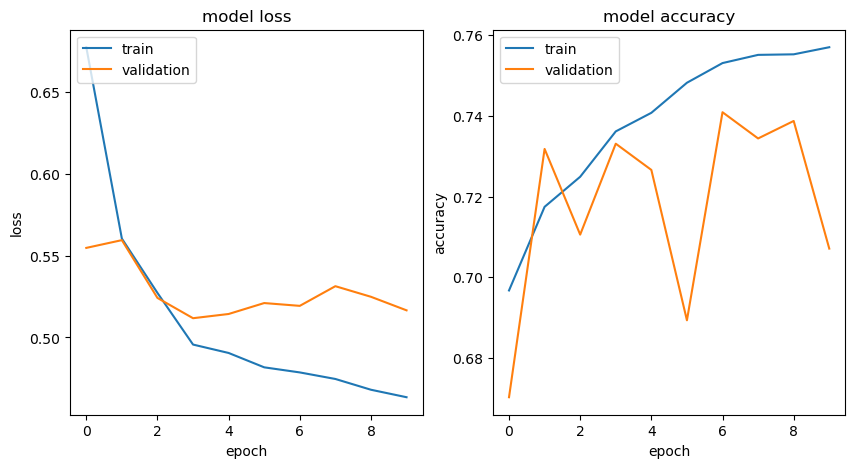

In [20]:
plot_curves(history, ['loss', 'accuracy'])

# Prediction accuracy

In [21]:
loss, accuracy = model.evaluate(test_ds)
print("Accuracy", accuracy)

73/73 [==============================] - 0s 3ms/step - loss: 0.5166 - accuracy: 0.7071
Accuracy 0.7071056962013245
